In [1]:
!pip install ta

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import ta
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LinearRegression

rcParams['figure.figsize']=(12,6)

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29088 sha256=a25194aa8df74875347548fd78ff5237c41061080d995bad690d130768f16942
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [2]:
df = yf.download('OJ=F')
juice_df = df.copy()
orange_df = df.copy()

[*********************100%***********************]  1 of 1 completed


In [3]:
orange_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [4]:
orange_df = orange_df[['Adj Close']]
orange_df.columns=['close']
orange_df.head()

,close
Date,
2021-09-07,147.000000
2021-09-08,143.100006
2021-09-09,144.250000
2021-09-10,147.100006
2021-09-13,142.100006


In [5]:
orange_df['SMA 15'] = orange_df.close.rolling(15).mean().shift(1)
orange_df['SMA 60'] = orange_df.close.rolling(60).mean().shift(1)
#Скользящее среднее

<Axes: xlabel='Date'>

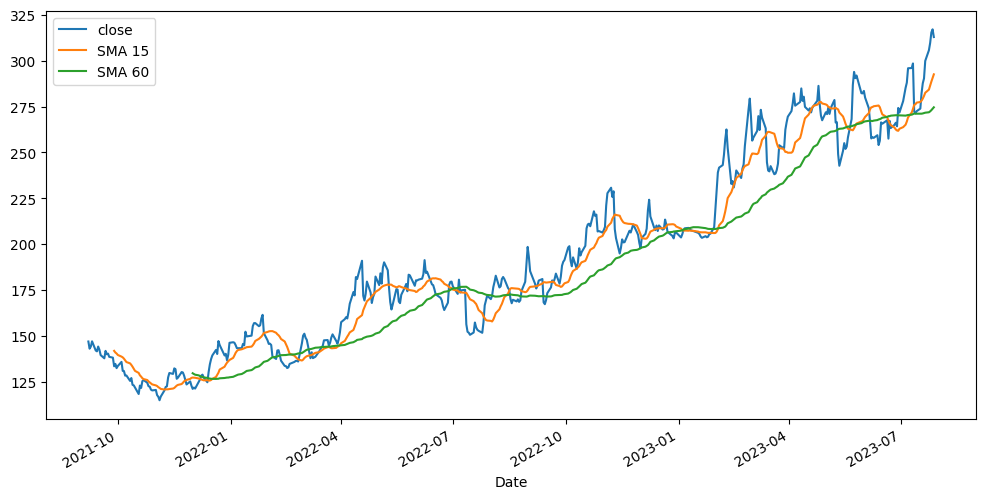

In [6]:
orange_df.plot()

In [7]:
orange_df['returns'] = orange_df.close.pct_change(1)
orange_df['MSD 15'] = orange_df.returns.rolling(15).std().shift(1)
orange_df['MSD 60'] = orange_df.returns.rolling(60).std().shift(1)

<Axes: xlabel='Date'>

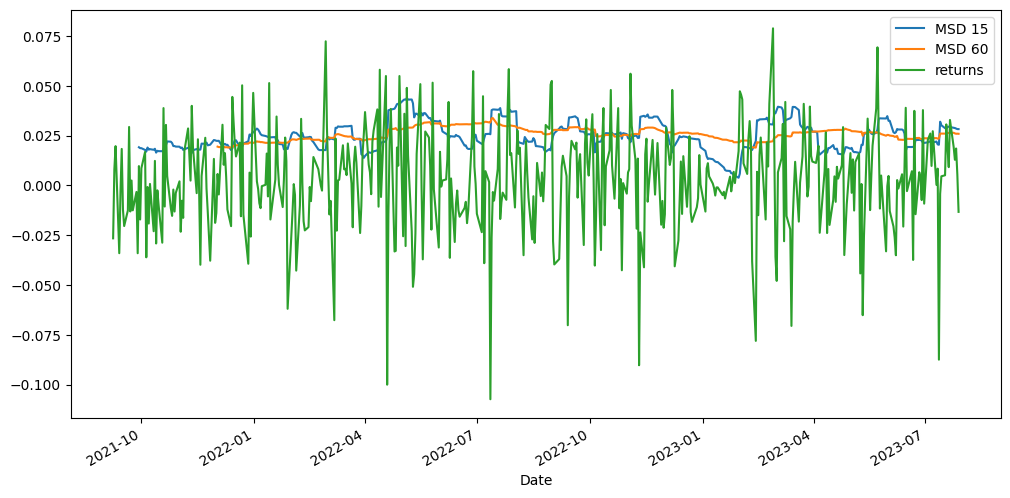

In [8]:
orange_df[['MSD 15', 'MSD 60', 'returns']].plot()

In [9]:
RSI = ta.momentum.RSIIndicator(orange_df.close)

In [10]:
orange_df['RSI'] = RSI.rsi()

<Axes: xlabel='Date'>

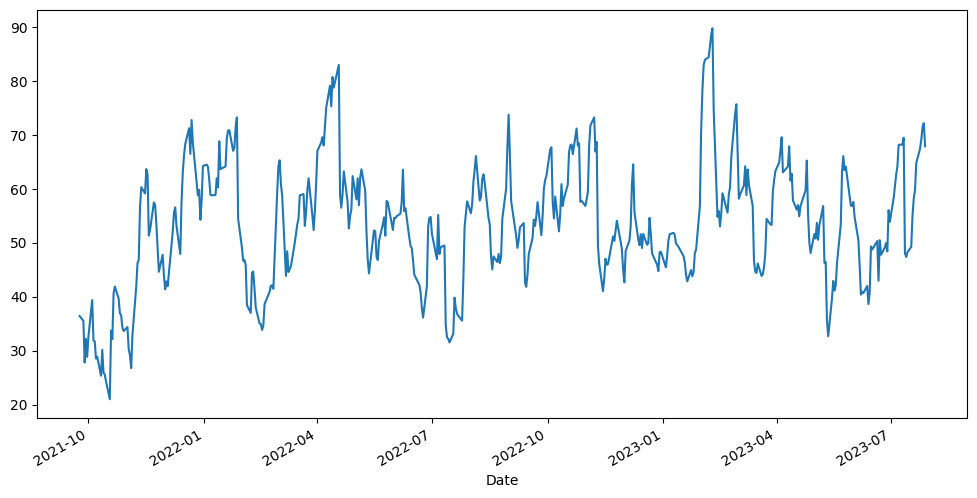

In [11]:
orange_df.RSI.plot()

# Linear Regression

In [12]:
orange_df.head(5)

,close,SMA 15,SMA 60,returns,MSD 15,MSD 60,RSI
Date,,,,,,,
2021-09-07,147.000000,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-08,143.100006,NaN,NaN,-0.026531,NaN,NaN,NaN
2021-09-09,144.250000,NaN,NaN,0.008036,NaN,NaN,NaN
2021-09-10,147.100006,NaN,NaN,0.019757,NaN,NaN,NaN
2021-09-13,142.100006,NaN,NaN,-0.033990,NaN,NaN,NaN


In [13]:
orange_df = orange_df.iloc[62:]

In [14]:
train_size = int(df.shape[0]*0.75)
X_tr, X_ts = orange_df[['SMA 15',	'SMA 60', 'MSD 15',	'MSD 60',	'RSI']].iloc[:train_size], orange_df[['SMA 15',	'SMA 60', 'MSD 15',	'MSD 60',	'RSI']].iloc[train_size:]
y_tr, y_ts = orange_df[['returns']].iloc[:train_size], orange_df[['returns']].iloc[train_size:]
X_tr.shape, X_ts.shape

((357, 5), (57, 5))

In [15]:
lr = LinearRegression()
lr.fit(X_tr, y_tr)

LinearRegression()

In [16]:
X = pd.concat([X_tr, X_ts], axis=0)

In [17]:
orange_df['prediction'] = lr.predict(X)

<ipython-input-17-353407d276eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orange_df['prediction'] = lr.predict(X)


<Axes: xlabel='Date'>

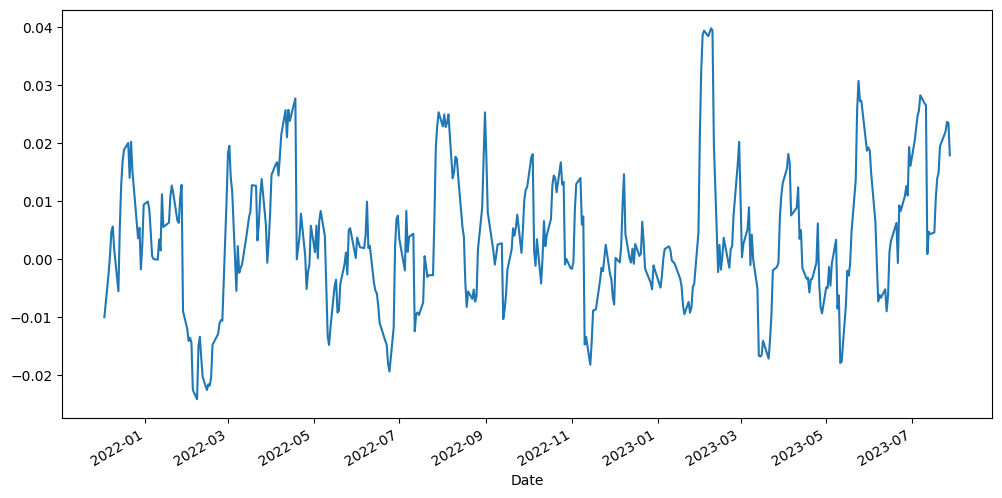

In [18]:
orange_df['prediction'].plot()

<ipython-input-19-4cbc9cffd895>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orange_df['position'] = np.sign(orange_df.prediction)
<ipython-input-19-4cbc9cffd895>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orange_df['strategy'] = orange_df.returns * orange_df.position.shift(1)


<Axes: xlabel='Date'>

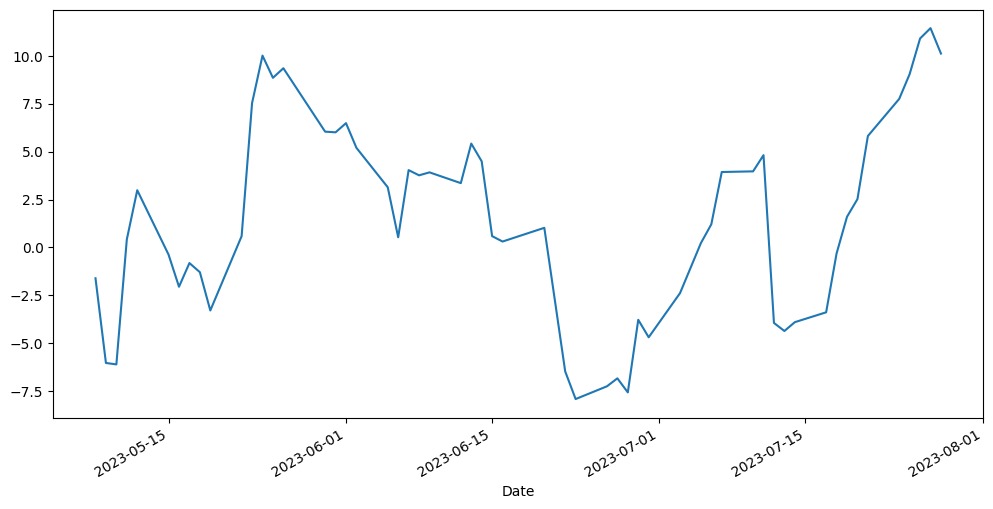

In [19]:
orange_df['position'] = np.sign(orange_df.prediction)
orange_df['strategy'] = orange_df.returns * orange_df.position.shift(1)
(orange_df.strategy.iloc[train_size:].cumsum()*100).plot()

# Alpha, Beta, Sortino Rate

In [35]:
return_series = juice_df['Adj Close'].pct_change(1).dropna()
return_series.name = 'return'

mean = return_series.mean()
vol = return_series[return_series<0].std()

sortino = 252**0.5 * mean/vol
print(f"Sortino: {'%.3f' % sortino}")

Sortino: 1.671


In [38]:
sp500 = yf.download('^GSPC')['Adj Close'].pct_change(1)
sp500.name = 'SP500'

val = pd.concat([return_series, sp500], axis=1).dropna()

cov_var_met = np.cov(val.values, rowvar=False)
cov = cov_var_met[0][1]
var = cov_var_met[1][1]

beta = cov/var
print(f"Beta: {'%.3f' % beta}")

[*********************100%***********************]  1 of 1 completed
Beta: -0.063


In [42]:
alpha = 252 * mean * (1 - beta) * 100
print(f"Alpha: {'%.3f' % alpha}")

Alpha: 51.349


# RNN

In [20]:
df = df.reset_index()

In [21]:
df.shape

(476, 7)

In [22]:
df.corr()

<ipython-input-22-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.998259,0.998519,0.996754,0.996754,-0.134545
High,0.998259,1.000000,0.998002,0.998779,0.998779,-0.112273
Low,0.998519,0.998002,1.000000,0.998382,0.998382,-0.146520
Close,0.996754,0.998779,0.998382,1.000000,1.000000,-0.126020
Adj Close,0.996754,0.998779,0.998382,1.000000,1.000000,-0.126020
Volume,-0.134545,-0.112273,-0.146520,-0.126020,-0.126020,1.000000


In [23]:
train = int(df.shape[0]*0.75)
X_train, X_test = df.iloc[:train], df.iloc[train:]
X_train.shape, X_test.shape

((357, 7), (119, 7))

In [24]:
X_train

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-09-07,147.000000,147.000000,147.000000,147.000000,147.000000,0
1,2021-09-08,145.550003,145.550003,144.000000,143.100006,143.100006,4
2,2021-09-09,144.250000,144.250000,144.250000,144.250000,144.250000,0
3,2021-09-10,147.100006,147.100006,147.100006,147.100006,147.100006,462
4,2021-09-13,141.649994,142.699997,140.899994,142.100006,142.100006,349
...,...,...,...,...,...,...,...
352,2023-01-31,209.449997,219.300003,209.000000,219.199997,219.199997,1609
353,2023-02-01,220.500000,229.199997,220.500000,229.199997,229.199997,2235
354,2023-02-02,230.550003,244.750000,230.550003,239.100006,239.100006,2353
355,2023-02-03,240.850006,245.149994,231.649994,241.750000,241.750000,1995


In [25]:
sc = StandardScaler()
sc.fit(X_train[['Low']])

StandardScaler()

In [26]:
def make_dataset(df, window_size, batch_size, use_scaler=True, shuffle=True):
  features = df[['Low']].iloc[:-window_size]
  if use_scaler:
    features = sc.transform(features)
  data = np.array(features, dtype=np.float32)
  ds = tf.keras.preprocessing. timeseries_dataset_from_array(data=data, targets=df['Low'].iloc[window_size:], sequence_length = window_size, sequence_stride=1, shuffle=shuffle, batch_size=batch_size)
  return ds

In [27]:
window_size = 10
batch_size=  5

X_tr_ds = make_dataset(df=X_train, window_size=window_size, batch_size=batch_size)
X_ts_ds = make_dataset(df=X_test, window_size=window_size, batch_size=batch_size)

In [28]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1)
])

In [29]:
def compile_fit(model, X_train, X_test, num_epochs: int=20):
  model.compile(
      loss=tf.losses.MeanSquaredError(),
      optimizer=tf.optimizers.Adam(),
      metrics=[tf.metrics.MeanAbsoluteError()]
  )
  history = model.fit(
      X_train, epochs=num_epochs,
      validation_data=X_test,\
      verbose=0
  )
  return history

In [30]:
history = compile_fit(lstm_model, X_tr_ds, X_ts_ds, num_epochs=100)

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['mean_absolute_error'])

In [ ]:
plt.plot(history.history['val_mean_absolute_error'])

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

history = compile_fit(lstm_model, X_tr_ds, X_ts_ds, num_epochs=100)

In [ ]:
lstm_model.evaluate(X_tr_ds)

In [ ]:
lstm_model.evaluate(X_ts_ds)